In [1]:
%matplotlib inline
import os
import csv

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import collections
import urllib2
import json
from shapely import geometry

# Ignore warnings from various packages.
import warnings
warnings.filterwarnings("ignore")

# Set project explicitly in the environment to suppress some warnings.
os.environ["GOOGLE_CLOUD_PROJECT"] = "measurement-lab"

# Load M-Lab site metadata including site latitude & longitude.
mlab_sites_config = 'https://storage.googleapis.com/operator-mlab-oti/metadata/v0/current/mlab-site-stats.json'

# Short list of metros in Africa, for convenience.
african_metros = ['tun', 'jnb', 'cpt', 'mpm', 'tnr', 'los', 'nbo', 'acc']

# Load the Natural Earth country shapes file.
country_shapes = os.path.expanduser('~/Downloads/ne_10m_admin_0_countries.shp')

# Number of colors to use when coloring maps.
colors = 10

# Default figure size. W x H.
figsize = (16, 10)

In [2]:
# Depends on: pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery

def run_query(query, project='measurement-lab'):
    client = bigquery.Client(project=project)
    job = client.query(query)

    results = collections.defaultdict(list)
    for row in job.result(timeout=600):
        for key in row.keys():
            results[key].append(row.get(key))

    return pd.DataFrame(results)

In [28]:
# Load shape data.
globe_raw = gpd.read_file('https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson')

# Select the global information (except Antarctica).
globe = globe_raw[['iso_a2', 'continent', 'geometry']].to_crs('+proj=longlat')
globe = globe[globe.continent != 'Antarctica']
# Add a new column with a default value of zero to show countries without data.
globe['default'] = 0

# Select only Africa.
africa = globe[globe.continent == 'Africa'].copy()
africa['default'] = 0
africa.sample(5)

,iso_a2,continent,geometry,default
134,MA,Africa,POLYGON ((-4.628320312499966 35.20639648437501...,0
201,ST,Africa,(POLYGON ((6.659960937499989 0.120654296874989...,0
83,GQ,Africa,"(POLYGON ((11.33466796875007 1.12075195312498,...",0
123,LR,Africa,POLYGON ((-8.486425781249977 7.558496093749994...,0
188,SS,Africa,"POLYGON ((33.95917968750001 9.845263671874989,...",0


In [4]:
# Download the M-Lab site configuration.
response = urllib2.urlopen(mlab_sites_config)
sites = json.loads(response.read())

# Collect all sites in Africa, creating a geometry.Point for each one.
all_map = {}
africa_map = {}
for row in sites:
    metro = row['site'][0:3]
    all_map[metro] = (metro, geometry.Point(row['longitude'], row['latitude']))
    if metro in african_metros:
        africa_map[metro] = all_map[metro]

# Convert the dict into a GeoDataFrame.
all_locations = gpd.GeoDataFrame(pd.DataFrame.from_dict(
    all_map, orient='index', columns=['metro', 'location']), geometry='location')
africa_locations = gpd.GeoDataFrame(pd.DataFrame.from_dict(
    africa_map, orient='index', columns=['metro', 'location']), geometry='location')

In [5]:
url = 'https://raw.githubusercontent.com/albertyw/avenews/master/old/data/average-latitude-longitude-countries.csv'

# Download the M-Lab site configuration.
response = urllib2.urlopen(url)
reader = csv.DictReader(response)

rows = {}
for row in reader:
    # "ISO 3166 Country Code","Country","Latitude","Longitude"
    rows[row['ISO 3166 Country Code']] = (
        row['ISO 3166 Country Code'],
        geometry.Point(float(row['Longitude']), float(row['Latitude'])),
        float(row['Latitude']),
        float(row['Longitude'])
    )

countries = pd.DataFrame.from_dict(rows, orient='index', columns=['iso', 'location', 'lat', 'lon'])
countries = gpd.GeoDataFrame(countries, geometry='location')
countries.sample(5)
#countries.index

,iso,location,lat,lon
GU,GU,POINT (144.78 13.47),13.47,144.78
IL,IL,POINT (34.75 31.5),31.50,34.75
GR,GR,POINT (22 39),39.00,22.00
BS,BS,POINT (-76 24.25),24.25,-76.00
TC,TC,POINT (-71.58 21.75),21.75,-71.58


In [6]:
print africa_locations.keys()

Index([u'metro', u'location'], dtype='object')


# Paris-Traceroute in Africa

How are clients in Africa routed to M-Lab servers?

Every time a client machine contacts and M-Lab server, the server starts a paris-traceroute from the M-lab server to the client remote IP. Each paris-traceroute hop is annotated with geo-location metadata for the intermediate router IP address, including the country. 

For a given day, the query below counts the hops in all countries visited between all clients in Africa and the African M-Lab server they contacted.

In [7]:
df_hops = {}
for metro in african_metros:
    print metro,
    df_hops[metro] = run_query("""
SELECT 
  paris_traceroute_hop.dest_geolocation.country_code as dest_country_code,
  COUNT(*) as hops
  
FROM
  `measurement-lab.traceroute.base`
  
WHERE
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-16")
  AND REGEXP_CONTAINS(test_id, r"mlab[1-4].%s\d\d")
  AND connection_spec.client_geolocation.continent_code = "AF"
  AND (REGEXP_CONTAINS(test_id, ".*3010.paris.gz") OR REGEXP_CONTAINS(test_id, ".*3001.paris.gz"))

GROUP BY
  dest_country_code

HAVING
  hops > 50

ORDER BY
  hops desc
""" % metro)

tun jnb cpt mpm tnr los nbo acc


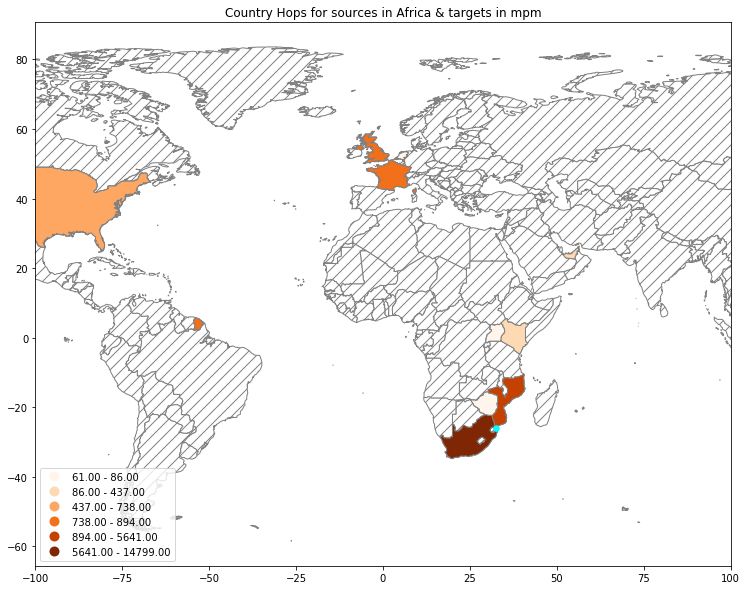

In [30]:
for metro in ['mpm']: # african_metros:
    if not len(df_hops[metro]):
        print "Skipping %s" % metro
        continue

    hops_merged = globe.merge(df_hops[metro], left_on='iso_a2', right_on='dest_country_code')

    ax1 = globe.plot(column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
    ax2 = hops_merged.plot(ax=ax1, column='hops', cmap='Oranges', scheme='Fisher_Jenks',
                           k=6, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')
    ax2.set_title('Country Hops for sources in Africa & targets in %s' % metro)
    africa_locations[africa_locations.metro == metro].plot(ax=ax2, color='cyan', markersize=30)
    ax2.set_xbound(-100, 100)


In [10]:
df_routes = {}
for metro in african_metros:
    print metro,
    df_routes[metro] = run_query("""
SELECT
  paris_traceroute_hop.src_geolocation.country_code as src_country_code,
  paris_traceroute_hop.dest_geolocation.country_code as dest_country_code,
  COUNT(*) as hops
  
FROM
  `measurement-lab.traceroute.base`
  
WHERE
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-16")
  AND REGEXP_CONTAINS(test_id, r"mlab[1-4].%s\d\d")
  AND connection_spec.client_geolocation.continent_code = "AF"
  AND (REGEXP_CONTAINS(test_id, ".*3010.paris.gz") OR REGEXP_CONTAINS(test_id, ".*3001.paris.gz"))

GROUP BY
  src_country_code, dest_country_code

HAVING
  hops > 50

ORDER BY
  hops desc
""" % metro)

 tun jnb cpt mpm tnr los nbo acc


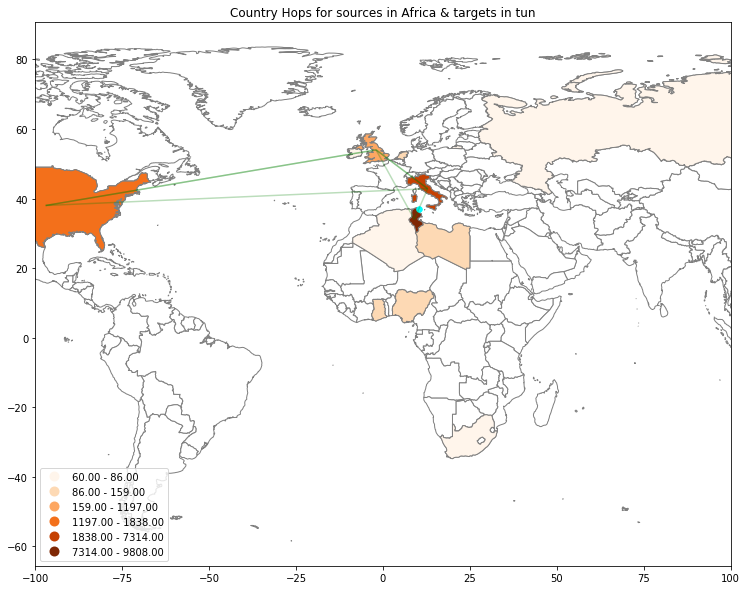

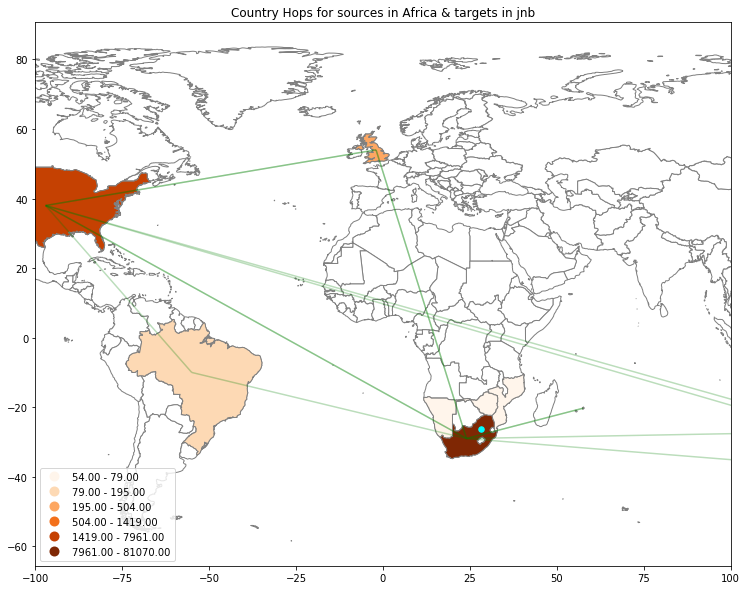

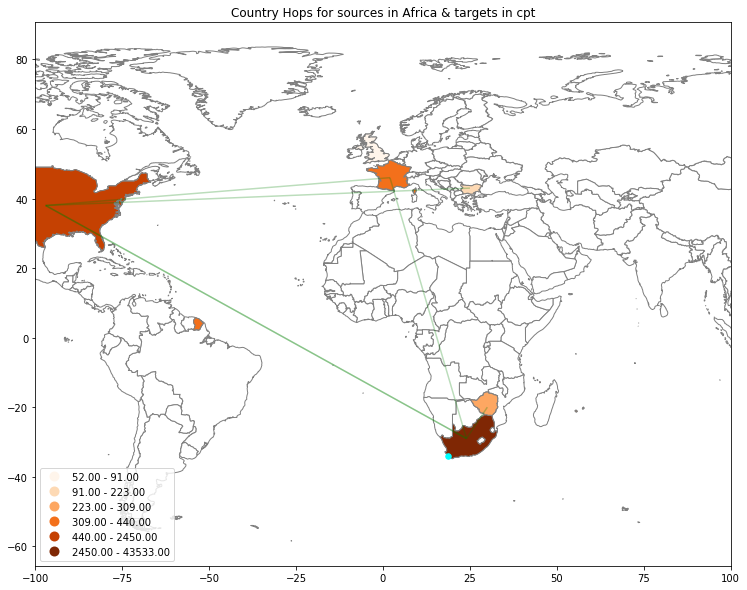

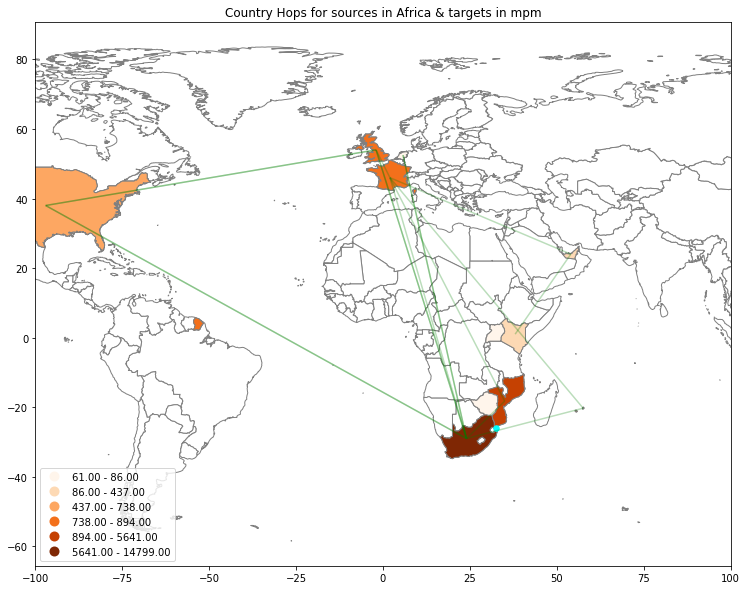

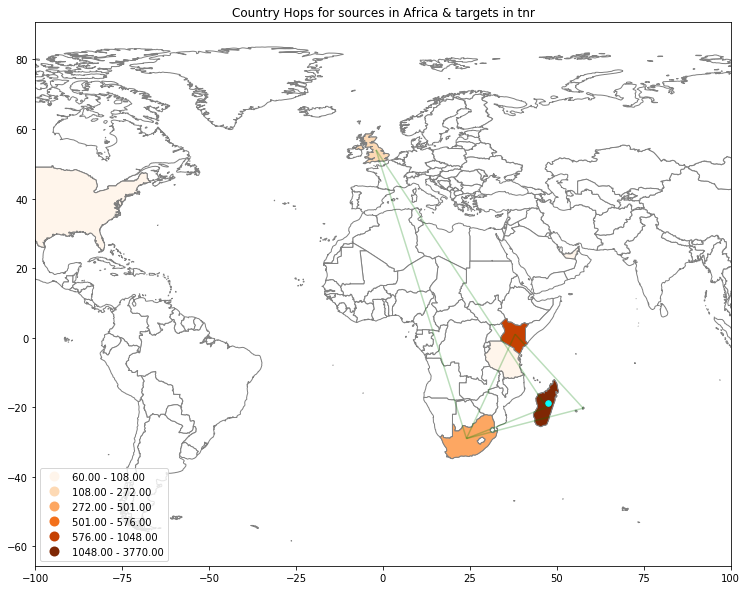

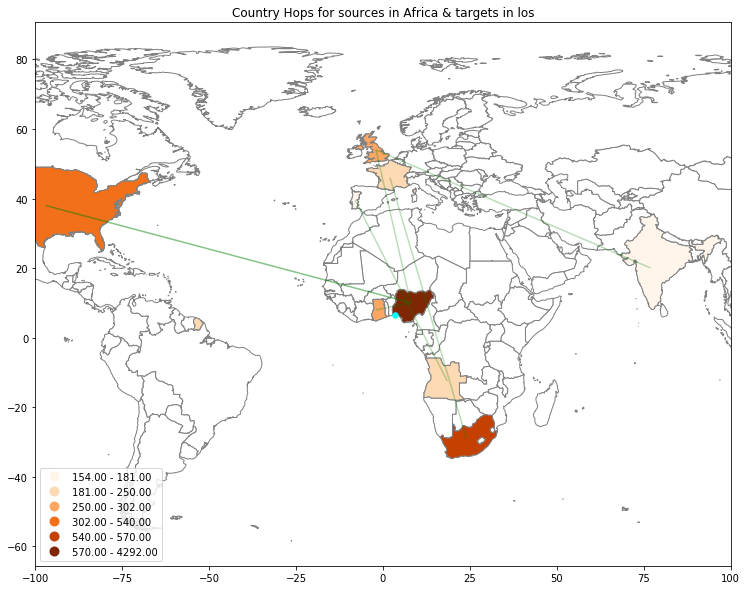

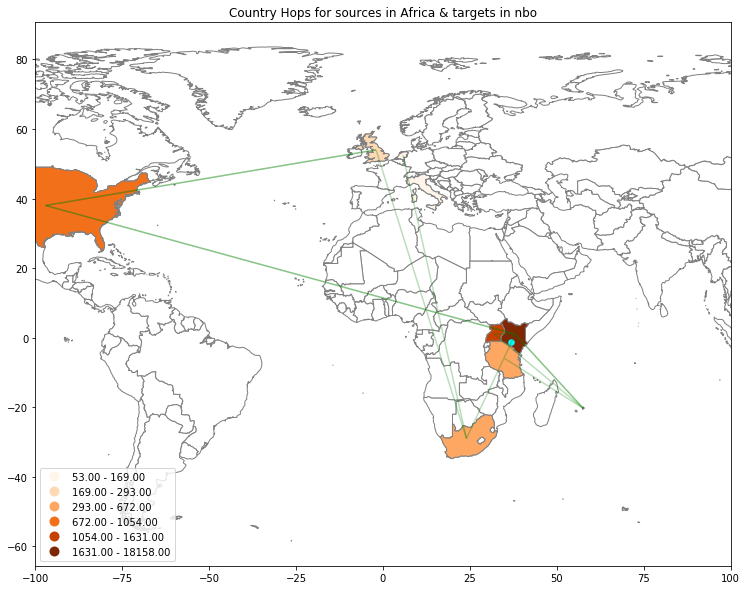

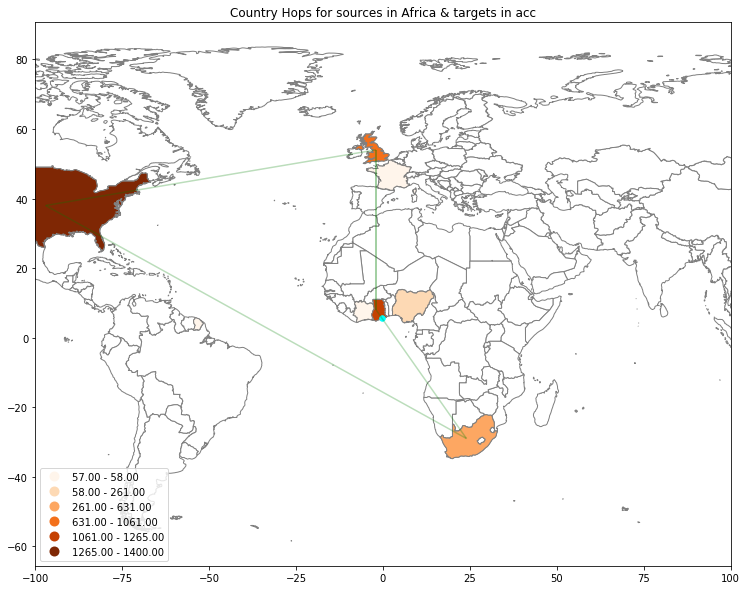

In [31]:
for metro in african_metros:
    if not len(df_routes[metro]):
        print "Skipping %s" % metro
        continue

    hops_merged = globe.merge(df_hops[metro], left_on='iso_a2', right_on='dest_country_code')

    ax1 = globe.plot(column='default', color='white', edgecolor='grey', figsize=figsize) # , hatch="//")
    ax2 = hops_merged.plot(ax=ax1, column='hops', cmap='Oranges', scheme='Fisher_Jenks',
                           k=6, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')
    ax2.set_title('Country Hops for sources in Africa & targets in %s' % metro)
    africa_locations[africa_locations.metro == metro].plot(ax=ax2, color='cyan', markersize=30)

#if False:
    hops = df_routes[metro][(df_routes[metro].dest_country_code != df_routes[metro].src_country_code) &
                            (df_routes[metro].dest_country_code != '') &
                            (df_routes[metro].src_country_code != '')].copy()
    #ax1 = globe.plot(column='default', color='white', edgecolor='grey', figsize=figsize)
    lines = []
    for i, row in hops.iterrows():
        dest = countries[countries.iso == row.dest_country_code]
        src = countries[countries.iso == row.src_country_code]

        lines.append((row['hops'], geometry.LineString([(src.lon, src.lat), (dest.lon, dest.lat)])))
        
    d = gpd.GeoDataFrame(lines, columns=['hops', 'line'], geometry='line')
    d.plot(ax=ax2, color='#00800044')
    ax2.set_xbound(-100, 100)




In [13]:
if False:
    for metro in african_metros:
        pass
        if not len(df_routes[metro]):
            print "Skipping %s" % metro
            continue
    
    hops = df_routes[metro][(df_routes[metro].dest_country_code != df_routes[metro].src_country_code) &
                            (df_routes[metro].dest_country_code != '') &
                            (df_routes[metro].src_country_code != '')].copy()
    ax1 = globe.plot(column='default', color='white', edgecolor='grey', figsize=figsize)
    lines = []
    for i, row in hops.iterrows():
        dest = countries[countries.iso == row.dest_country_code]
        src = countries[countries.iso == row.src_country_code]
        lines.append((row['hops'], geometry.LineString([(src.lon, src.lat), (dest.lon, dest.lat)])))
        
    d = gpd.GeoDataFrame(lines, columns=['hops', 'line'], geometry='line')
    d.plot(ax=ax1, color='#ff000044')


In [14]:
df_hops['mpm']

,dest_country_code,hops
0,ZA,14799
1,MZ,5641
2,FR,894
3,GB,847
4,US,738
5,,450
6,KE,437
7,MU,436
8,AE,431
9,NL,86


In [15]:
df_routes['mpm']

,dest_country_code,hops,src_country_code
0,ZA,11981,ZA
1,MZ,5530,MZ
2,ZA,1887,MZ
3,FR,680,MZ
4,US,402,US
5,ZA,367,GB
6,GB,330,GB
7,AE,314,AE
8,GB,313,ZA
9,KE,258,KE
